In [1]:
%matplotlib ipympl

import matplotlib.pyplot as pl
import xarray as xr
import pandas as pd
import numpy as np

import microhhpy as mpy

from read_maq import read_maq_obs

In [2]:
"""
Help functions.
"""
M_co2 = 44.01
M_air = 28.97

def colocate(
        name_1, time_1, var_1,
        name_2, time_2, var_2):
    """
    Collocate two time series into one Pandas dataframe
    """
    ds1 = pd.DataFrame({name_1: var_1}, index=time_1)
    ds1.index = ds1.index.round('1s')

    ds2 = pd.DataFrame({name_2: var_2}, index=time_2)
    ds2.index = ds2.index.round('1s')

    ds = pd.concat([ds1, ds2], axis=1)
    ds.dropna(inplace=True)

    return ds


def colocate_multi(times, variables, names):
    """
    Collocate multiple time series into one Pandas dataframe
    """
    dss = []
    for time, variable, name in zip(times, variables, names):
        ds = pd.DataFrame({name: variable}, index=time)
        ds.index = ds.index.round('1s')
        dss.append(ds)

    ds = pd.concat(dss, axis=1)
    ds.dropna(inplace=True)

    return ds

In [3]:
"""
Read data from Cabauw and MicroHH.
"""

data_path = '/home/scratch2/bart/slocs_rf/'
obs_path = f'{data_path}/observations/maq_observations/'

# Read LASSIE experiment.
nc_file = '/home/scratch2/bart/slocs_rf/sims_periodic/loobos_ags_sm0/ruisdael_testbed.default.0000000.nc'
ds1 = mpy.io.netcdf_io.xr_open_groups(nc_file)

nc_file = '/home/scratch2/bart/slocs_rf/sims_periodic/loobos_ags_sm25/ruisdael_testbed.default.0000000.nc'
ds2 = mpy.io.netcdf_io.xr_open_groups(nc_file)

nc_file = '/home/scratch2/bart/slocs_rf/sims_periodic/loobos_ags_sm20_R0/ruisdael_testbed.default.0000000.nc'
ds3 = mpy.io.netcdf_io.xr_open_groups(nc_file)

# Read Loobos observations.
df_met, df_prec, df_flux, df_aq, df_soil = read_maq_obs(obs_path, 'Loobos', 2022)
df_flux['co2_flux'] *= (M_co2 / 1000)

Text(0, 0.5, 'LE (W m-2)')

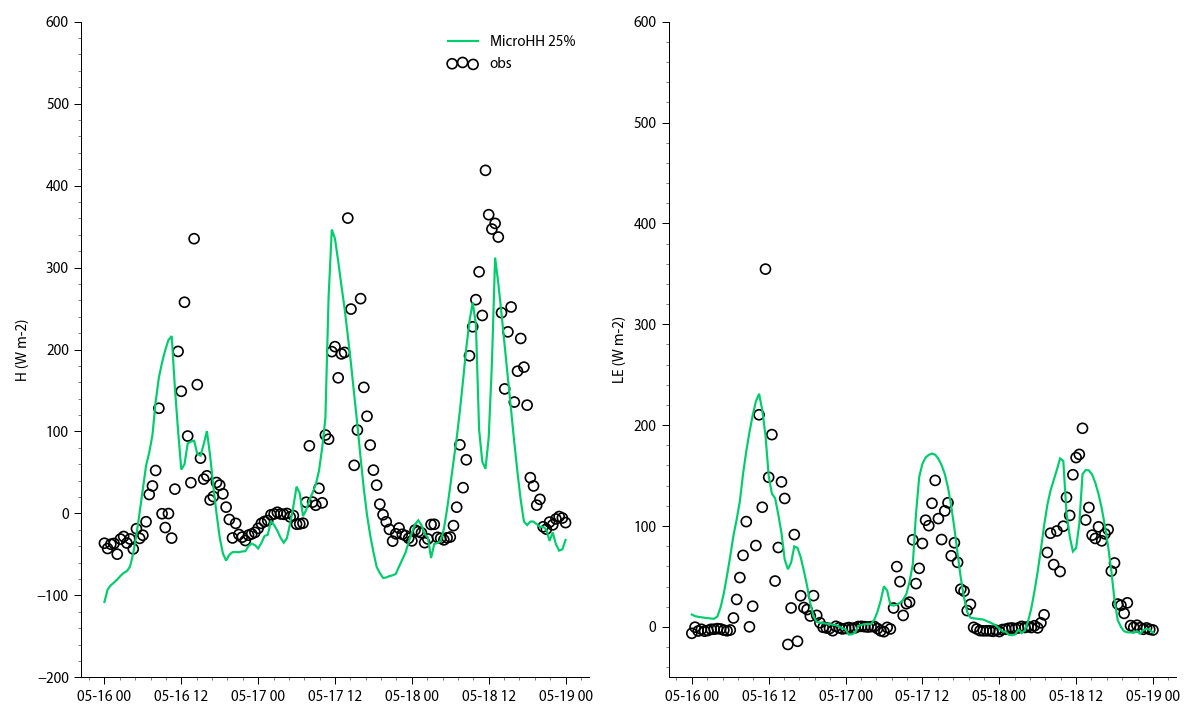

In [4]:
"""
Validate: surface fluxes.
"""
pl.close('all')


names = ['obs', 'mhh1', 'mhh2', 'mhh3']
times = [df_flux.index, ds1.time, ds2.time, ds3.time]

H = colocate_multi(times, [df_flux.H, ds1.H, ds2.H, ds3.H], names)
L = colocate_multi(times, [df_flux.LE, ds1.LE, ds2.LE, ds3.H], names)

pl.figure(figsize=(10,6), layout='tight')

ax=pl.subplot(121)
#pl.plot(H.index, H.mhh1, color='C0', label='MicroHH 0%')
pl.plot(H.index, H.mhh2, color='C1', label='MicroHH 25%')
#pl.plot(H.index, H.mhh3, color='C2', label='MicroHH 20% R0')
pl.scatter(H.index, H.obs, facecolor='none', edgecolor='k', label='obs')
pl.ylim(-200, 600)
pl.legend()
pl.ylabel('H (W m-2)')

pl.subplot(122, sharex=ax)
#pl.plot(L.index, L.mhh1, color='C0')
pl.plot(L.index, L.mhh2, color='C1')
#pl.plot(L.index, L.mhh3, color='C2')
pl.scatter(L.index, L.obs, facecolor='none', edgecolor='k')
pl.ylim(-50, 600)
pl.ylabel('LE (W m-2)')

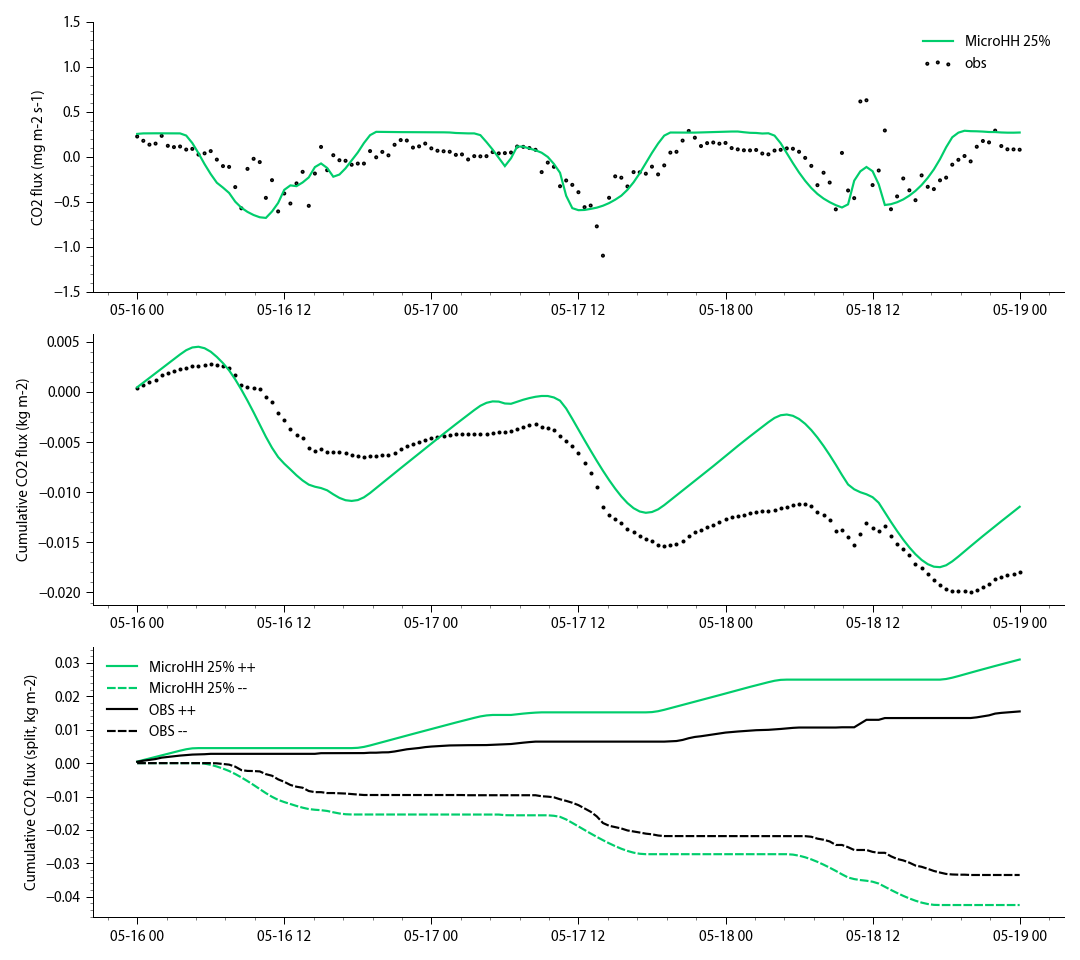

In [5]:
"""
CO2 fluxes
"""
fac = M_co2/M_air * ds1.rhorefh[0] * 1e6

co2_an1 = ds1.co2_an * fac
co2_re1 = ds1.co2_resp * fac

co2_an2 = ds2.co2_an * fac
co2_re2 = ds2.co2_resp * fac

co2_an3 = ds3.co2_an * fac
co2_re3 = ds3.co2_resp * fac


names = ['obs', 'mhh1', 'mhh2', 'mhh3']
times = [df_flux.index, ds1.time, ds2.time, ds3.time]

fco2  = colocate_multi(times, [df_flux.co2_flux, co2_an1+co2_re1, co2_an2+co2_re2, co2_an3+co2_re3], names)
fco2a = colocate_multi(times, [df_flux.co2_flux, co2_an1, co2_an2, co2_an3], names)
fco2r = colocate_multi(times, [df_flux.co2_flux, co2_re1, co2_re2, co2_re3], names)

dt = float((fco2.index[1] - fco2.index[0]).total_seconds())

pl.figure(figsize=(9,8), layout='tight')
ax=pl.subplot(311)
#pl.plot(fco2.index,    fco2.mhh1,  color='C0', label='MicroHH 0%')
pl.plot(fco2.index,    fco2.mhh2,  color='C1', label='MicroHH 25%')
#pl.plot(fco2.index,    fco2.mhh3,  color='C2', label='MicroHH 50%')
pl.scatter(fco2.index, fco2.obs, s=2,  edgecolor='k', facecolor='none', label='obs')
pl.ylabel('CO2 flux (mg m-2 s-1)')
pl.ylim(-1.5, 1.5)
pl.legend()

pl.subplot(312,sharex=ax)
#pl.plot(fco2.index, np.cumsum(fco2.mhh1)*dt*1e-6, color="C0")
pl.plot(fco2.index, np.cumsum(fco2.mhh2)*dt*1e-6, color="C1")
#pl.plot(fco2.index, np.cumsum(fco2.mhh3)*dt*1e-6, color="C2")
pl.scatter(fco2.index, np.cumsum(fco2.obs  )*dt*1e-6, s=2, color='k')
pl.ylabel('Cumulative CO2 flux (kg m-2)')

pl.subplot(313,sharex=ax)
#pl.plot(fco2.index, np.cumsum(np.maximum(0, fco2.mhh1))*dt*1e-6, color='C0', label='MicroHH 0% ++')
#pl.plot(fco2.index, np.cumsum(np.minimum(0, fco2.mhh1))*dt*1e-6, color='C0', dashes=[4,1], label='MicroHH 0% --')
#
pl.plot(fco2.index, np.cumsum(np.maximum(0, fco2.mhh2))*dt*1e-6, color='C1', label='MicroHH 25% ++')
pl.plot(fco2.index, np.cumsum(np.minimum(0, fco2.mhh2))*dt*1e-6, color='C1', dashes=[4,1], label='MicroHH 25% --')

#pl.plot(fco2.index, np.cumsum(np.maximum(0, fco2.mhh3))*dt*1e-6, color='C2', label='MicroHH 20% R0 ++')
#pl.plot(fco2.index, np.cumsum(np.minimum(0, fco2.mhh3))*dt*1e-6, color='C2', dashes=[4,1], label='MicroHH 20% R0 --')

pl.plot(fco2.index, np.cumsum(np.maximum(0, fco2.obs))*dt*1e-6, color='k', label='OBS ++')
pl.plot(fco2.index, np.cumsum(np.minimum(0, fco2.obs))*dt*1e-6, color='k', dashes=[4,1], label='OBS --')
pl.ylabel('Cumulative CO2 flux (split, kg m-2)')
pl.legend()